# Raymarching Visualization

In [25]:
# Raymarching illustration in SageMath 3D
# Using vector() and Sage's plotting utilities

from sage.all import *
from sage.plot.plot3d.shapes2 import sphere
from sage.plot.plot3d.shapes import arrow3d

# ---------- Scene parameters ----------
eye = vector([0, -3, 0])       # camera/eye position
img_y = 0.0                    # y-position of the image plane
uv_min, uv_max = -1.0, 1.0     # horizontal UV range
res_x, res_z = 5, 5                     # number of pixels across
max_steps = 100
max_dist = 6.0
hit_eps = 1e-3

# Sphere geometry
sphere_center = vector([0., 2., 0.])
sphere_radius = 0.8

# ---------- SDF Functions ----------
def sdf_sphere(p, center=sphere_center, r=sphere_radius):
    """Signed distance to a sphere (2D XY, Z fixed at 0)."""
    return (p - center).norm() - r

def scene_sdf(p):
    return sdf_sphere(p)

def normalize(v):
    n = v.norm()
    return v / n if n > 0 else v

# ---------- Raymarching ----------
# Start with an empty scene
plot_obj = sphere(center=eye, size=0.0, color='white', opacity=0)  # invisible placeholder

# Add sphere object
plot_obj += sphere(center=sphere_center, size=sphere_radius, color="lightblue", opacity=0.4)

# Add image plane as a transparent rectangle
pixel_width = (uv_max - uv_min) / res_x
pixel_height = (uv_max - uv_min) / res_z
for ix in range(res_x):
    for iz in range(res_z):
        x0 = uv_min + ix * pixel_width
        z0 = uv_min + iz * pixel_height
        rect = [
            (x0, img_y, z0),
            (x0+pixel_width, img_y, z0),
            (x0+pixel_width, img_y, z0+pixel_height),
            (x0, img_y, z0+pixel_height)
        ]
        plot_obj += polygon3d(rect, color="lightgray", opacity=0.5)

# Add eye point
plot_obj += sphere(center=eye, size=0.05, color="black")

# Loop over pixels
for ix in range(res_x):
    for iz in range(res_z):
        # Pixel Center by move 0.0 to 0.5 for ray representation
        ux = uv_min + (ix + 0.5) * pixel_width
        uz = uv_min + (iz + 0.5) * pixel_height
        target = vector([ux, img_y, uz])
        direction = normalize(target - eye) # normalize it only to get direction of the vector
        t = 0.0
        hit = False
        for step in range(max_steps):
            p = eye + direction * t
            d = scene_sdf(p)
            if d < hit_eps:
                hit = True
                break
            t += d
            if t >= max_dist:
                break
        endpoint = eye + direction * min(t, max_dist)
    
        # Arrow for ray
        color = "green" if hit else "gray"
        plot_obj += arrow3d(eye, endpoint, color=color, width=0.1, head_radius=0.05)

        # Red dot at hit point
        if hit:
            plot_obj += sphere(center=endpoint, size=0.03, color="red")

# Show plot
plot_obj.show(frame=False, aspect_ratio=1)


Graphics3d Object

### Behind The Scene (Mathematics)

Let's build UV on a plane to ray points based on each pixels.

> In this case for the sake of performance, the resolution would be very very low only for display purposes since this calculation is done only by CPU (With memory causes). Only GPU can run parallel without memory usage and performance fast.

These are the values for reference:
- `eye` is camera or eye position
- `img_y` The height of a pixel plane
- `uv_min` is horizontal for UV Range minimum
- `uv_max` is horizontal for UV Range maximum
- `res_x` is resolution for X axis
- `res_z` is resolution for z axis
- `max_steps` maximum steps for raymarching
- `max_dist` maximum distance for raymarching
- `hit_eps` Hit epsilon $\epsilon$ for how close the ray should hit

1. Get `pixel_width` for pixel width on a UV plane. Assume $p_w$ is a `pixel_width`.

$$p_w = \frac{(uv\_max - uv\_min)}{res\_x}$$

In [26]:
pixel_width

0.400000000000000

2. Get `pixel_height` for pixel height on a UV plane. Assume $p_h$ is a `pixel_height`.

$$p_h = \frac{(uv\_max - uv\_min)}{res\_z}$$

In [27]:
pixel_height

0.400000000000000

3. Get `x0` for Polygon 3D vertex point
$$x0 = \sum_{ix=0}^{res\_x}\sum_{iz=0}^{res\_z}uv\_min + (ix * p_w)$$

In [28]:
for ix in range(res_x):
    for iz in range(res_z):
        x0 = uv_min + (ix * pixel_width)

x0

0.600000000000000

4. Get `z0` for Polygon 3D vertex point
$$x0 = \sum_{ix=0}^{res\_x}\sum_{iz=0}^{res\_z}uv\_min + (iz * p_h)$$

In [29]:
for ix in range(res_x):
    for iz in range(res_z):
        z0 = uv_min + (iz * pixel_height)

z0

0.600000000000000

5. Set `rect` 4 points using $x0$ and $z0$:
$$
rect = [
            (x0, img\_y, z0),
            (x0+pixel\_width, img\_y, z0),
            (x0+pixel\_width, img\_y, z0+pixel\_height),
            (x0, img\_y, z0+pixel\_height)
        ]
$$

In [30]:
rect = [
            (x0, img_y, z0),
            (x0+pixel_width, img_y, z0),
            (x0+pixel_width, img_y, z0+pixel_height),
            (x0, img_y, z0+pixel_height)
        ]
rect

[(0.600000000000000, 0.000000000000000, 0.600000000000000),
 (1.00000000000000, 0.000000000000000, 0.600000000000000),
 (1.00000000000000, 0.000000000000000, 1.00000000000000),
 (0.600000000000000, 0.000000000000000, 1.00000000000000)]

In [31]:
polygon(rect, color="lightblue", opacity=1.0).show()

Graphics3d Object

## Raymarching With Sphere on array hit

In [ ]:
from sage.all import *
from sage.plot.plot3d.shapes2 import sphere
from sage.plot.plot3d.shapes import arrow3d


# Sphere geometry
sphere_center = vector([0.0, 1.2, 0.0])
sphere_radius = 0.8

# ---------- SDF Functions ----------
def sdf_sphere(p, center=sphere_center, r=sphere_radius):
    return (p - center).norm() - r

def scene_sdf(p):
    return sdf_sphere(p)

def normalize(v):
    n = v.norm()
    return v / n if n > 0 else v

@interact
def render(ball_hit=False, ball_opacity=slider([0.0, 0.1, .. 1.0])):
    # ---------- Scene parameters ----------
    eye = vector([0, -4, 0])       # camera position
    img_y = 0.0                    # image plane y-position
    uv_min, uv_max = -1.0, 1.0     # horizontal UV range
    res_x, res_z = 5, 5            # pixel resolution (small for clarity)
    max_steps = 10
    max_dist = 6.0
    hit_eps = 1e-3

    # ---------- Raymarching visualization ----------
    plot_obj = sphere(center=eye, size=1.0, color='white', opacity=0)  # start empty
    
    # Add sphere object
    plot_obj += sphere(center=sphere_center, size=sphere_radius, color="lightblue", opacity=1.0)

    # Add image plane as a transparent grid
    pixel_width = (uv_max - uv_min) / res_x
    pixel_height = (uv_max - uv_min) / res_z
    for ix in range(res_x):
        for iz in range(res_z):
            x0 = uv_min + ix * pixel_width
            z0 = uv_min + iz * pixel_height
            rect = [
                (x0, img_y, z0),
                (x0+pixel_width, img_y, z0),
                (x0+pixel_width, img_y, z0+pixel_height),
                (x0, img_y, z0+pixel_height)
            ]
            plot_obj += polygon3d(rect, color="lightgray", opacity=0.5)
    
    # Add eye point
    plot_obj += sphere(center=eye, size=0.05, color="black")
    
    # Loop over pixels
    for ix in range(res_x):
        for iz in range(res_z):
            # Pixel center
            px = uv_min + (ix + 0.5) * pixel_width
            pz = uv_min + (iz + 0.5) * pixel_height
            target = vector([px, img_y, pz])
            
            direction = normalize(target - eye)
            t = 0.0
            hit = False
            
            # Marching steps
            for step in range(max_steps):
                p = eye + direction * t
                d = scene_sdf(p)
                
                # Draw step sphere to visualize SDF radius
                plot_obj += sphere(center=p, size=d if t > hit_eps else 0.00, color="yellow", opacity=ball_opacity if ball_hit else 0.00)
                
                if d < hit_eps:
                    hit = True
                    break
                t += d
                if t >= max_dist:
                    break
            
            endpoint = eye + direction * min(t, max_dist)
            color = "green" if hit else "gray"
            plot_obj += arrow3d(eye, endpoint, color=color, width=0.005, radius=0.01)
            
            if hit:
                plot_obj += sphere(center=endpoint, size=0.03, color="red")
    
    # Show plot
    plot_obj.show(frame=True, aspect_ratio=1)


Interactive function <function render at 0x16b9cd080> with 2 widgets
  ball_hit: Checkbox(value=False, description='ball_hit')
  ball_opacity: SelectionSlider(description='ball_opacity', options=(0.000000000000000, 0.100000000000000, 0.200000000000000, 0.300000000000000, 0.400000000000000, 0.500000000000000, 0.600000000000000, 0.700000000000000, 0.800000000000000, 0.900000000000000, 1.00000000000000), value=0.000000000000000)

# SDF Normals
The surfaces that emerge from an SDF `f(p)`, where `p` is a point in space, are given by a particular iso-surface, normally the `f(p) = 0` isosurface. Computing the normal n of that isosurfaces can be done through the [gradient](https://en.wikipedia.org/wiki/Gradient) of the SDF at points located on the surface.

$n = normalize(\nabla{f(p)})$

> Remember that the gradient of a scalar field is always perpendicular to the iso-lines or iso-surfaces described by the scalar field, and since the normals to a surface need to be perpendicular, the normals must align with the gradient.

### How Gradient Works in background
Before evaluating some vector-field operators, one needs to define the arena in which vector fields live, namely the 3-dimensional Euclidean space $\mathbb{E}^{3}$. In SageMath, we declare it, along with the standard Cartesian coordinates $(x,y,z)$, via `EuclideanSpace`:

In [33]:
from sage.all import *
E = EuclideanSpace(names=('x', 'y', 'z',))
x, y, z, = E._first_ngens(3) # Get x, y & z value

We define a vector field on $\mathbb{E^3}$ from its components in the vector frame $(e_x, e_y, e_z)$

In [34]:
v = E.vector_field(-y, x, sin(x*y*z), name='v')

Then we can try look how it plotted:

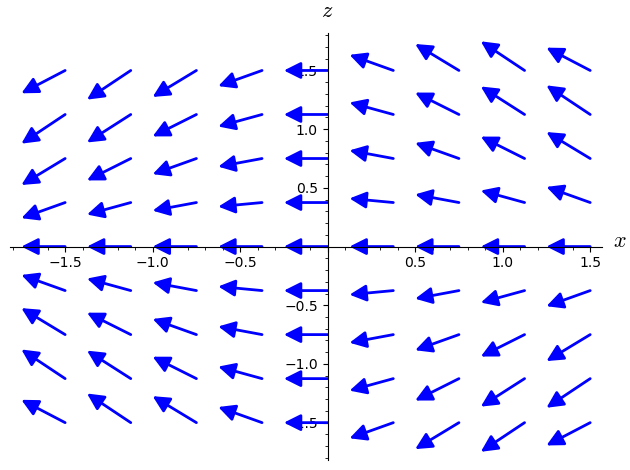

In [35]:
v.plot(fixed_coords={y: Integer(1)}, ambient_coords=(x,z), max_range=RealNumber('1.5'),
        scale=RealNumber('0.25'))

How it looks in 3Dm

In [36]:
v.plot(max_range=RealNumber('1.5'), scale=RealNumber('0.5'))

Graphics3d Object

In [37]:
v.display()

v = -y e_x + x e_y + sin(x*y*z) e_z